<a href="https://colab.research.google.com/github/TomaszK98/growingneuralgas/blob/main/Growing_Neural_Gas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Neupy library


In [ ]:
pip install neupy

Upload image 

In [ ]:
import cv2
from google.colab import files

uploaded = files.upload()

Saving Color_shapes.png to Color_shapes.png


Read and convert image to ndarray

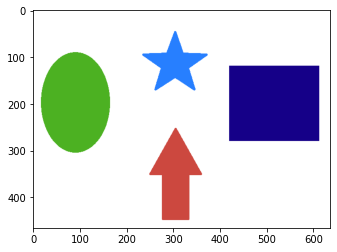

In [ ]:
import matplotlib.pyplot as plt

image = cv2.imread("Color_shapes.png")
plt.imshow(image);

Convert image to binary reprezentation

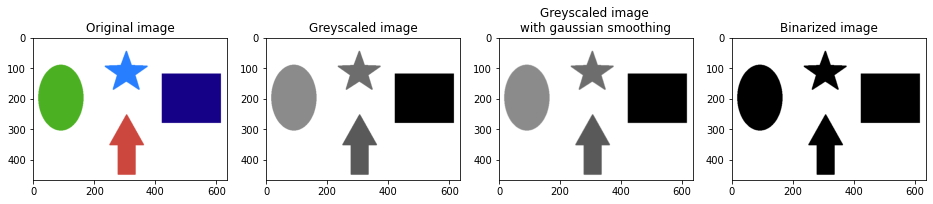

In [ ]:
from skimage.filters import threshold_otsu, threshold_local, gaussian
from skimage import color

plt.figure(figsize=(16, 6))

plt.subplot(141)
plt.title("Original image")
plt.imshow(image)

image_grey = color.rgb2grey(image)

plt.subplot(142)
plt.title("Greyscaled image")
plt.imshow(image_grey, cmap='gray')

# We added gaussian smoothing in order to reduce
# number of very small regions
image_grey = gaussian(image_grey, sigma=0.6)

plt.subplot(143)
plt.title("Greyscaled image \nwith gaussian smoothing")
plt.imshow(image_grey, cmap='gray')

# Increase threshold in order to add more
# details to the binarized image
threshold_adjustment = 0.1
thresh = threshold_otsu(image_grey) + threshold_adjustment
binary_image = image_grey < thresh

plt.subplot(144)
plt.title("Binarized image")
plt.imshow(image_grey > thresh, cmap='gray');

Convert each black pixel to a separate data point

Number of data points: 74,603


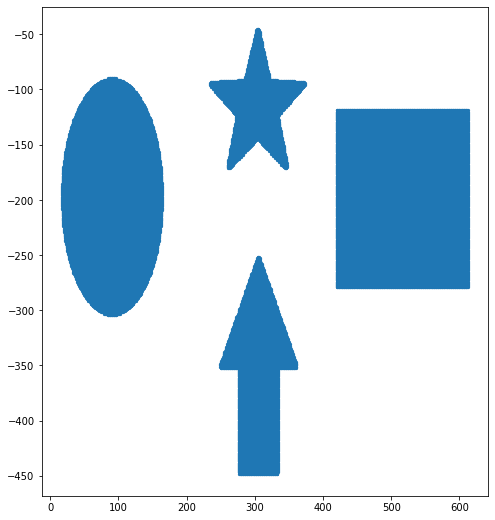

In [ ]:
import numpy as np

def image_to_data(img):
    data = []
    for (x, y), value in np.ndenumerate(img):
        if value == 1:
            data.append([y, -x])
    return data

# Convert each black pixel to a separate data point
# We will use these data points in order to learn
# topological structure of the image
data = image_to_data(binary_image)

# Scaling factor allows us to reduce distance between data points
scale_factor = 0.001   
data = scale_factor * np.array(data)
print("Number of data points: {:,}".format(len(data)))

plt.figure(figsize=(8, 9))
plt.scatter(*np.array(data).T / scale_factor, s=5, alpha=1);

Generate Growing Neural Gas algorithm

1.   Create animation
2.   Create finished image





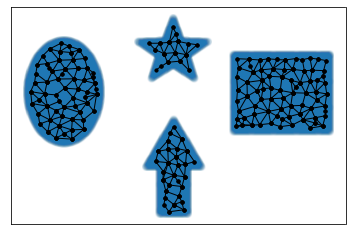

In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
from neupy import algorithms, utils
    
utils.reproducible()

gng = algorithms.GrowingNeuralGas(
    n_inputs=2,
    n_start_nodes=2,

    shuffle_data=True,
    verbose=False,
    
    step=0.1,
    neighbour_step=0.001,
    
    max_edge_age=50,
    max_nodes=1000,
    
    n_iter_before_neuron_added=100,
    after_split_error_decay_rate=0.5,
    error_decay_rate=0.995,
    min_distance_for_update=0.01,
)

fig = plt.figure()
plt.scatter(*data.T, alpha=0.02)
plt.xticks([], [])
plt.yticks([], [])

def animate(i):
    for line in animate.prev_lines:
        line.remove()
        
    # Training will slow down overtime and we increase number
    # of data samples for training
    n = int(0.5 * gng.n_iter_before_neuron_added * (1 + i // 100))
    
    sampled_data_ids = np.random.choice(len(data), n)
    sampled_data = data[sampled_data_ids, :]
    gng.train(sampled_data, epochs=1)
    
    lines = []
    for node_1, node_2 in gng.graph.edges:
        weights = np.concatenate([node_1.weight, node_2.weight])
        line, = plt.plot(*weights.T, color='black')

        plt.setp(line, linewidth=1, color='black')
        
        lines.append(line)
        lines.append(plt.scatter(*weights.T, color='black', s=10))
    
    animate.prev_lines = lines
    return lines

animate.prev_lines = []
anim = animation.FuncAnimation(fig, animate, tqdm(np.arange(220)), interval=30, blit=True)
HTML(anim.to_html5_video())